In [162]:
# change notes 11/22/24 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# moved data.yaml, model, and dataset locations to LOCAL dir preventing model training path errors
# updated yaml.data to all 10 construction classes to prevent model training IndexError

# added markdowns
# added suggested WIP
# added new datasets link

# added label dir splitting process
# prevented raw_images and raw_labels from being cleared to keep for multiple runs

# trained model from custom labels and construction dataset labels
# added model result images
# added print for model train execution time
# used model to draw bbox instead of function
# added test image and predicted image *from custom dataset*
# cleared runs and predictions for each execution
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# change notes 11/24/24 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

# added image augmentations to custom dataset for model training
# updated model training to 60 epochs from 30 epochs
# updated wip and added 11/24 change notes
# prediction Intersection Over Union parameter (iou) decreased to 0.4 from 0.7
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

## Dataset (2859 raw_images and 2859 raw_labels):

construction_ppe: 2851 images
https://www.kaggle.com/datasets/snehilsanyal/construction-site-safety-image-dataset-roboflow/code
<br>custom dataset: 58 images
<br><br>
download new contstruction+custom "datasets" folder 
<br>to<u><b> local script directory </u></b> (will be ignored to git):
<br>https://uofsandiego-my.sharepoint.com/:f:/g/personal/dverduzco_sandiego_edu/ErhP9WM76B9Ho2PhSeBd13UB0fADbGPbVfGnB6LPDl_kUw?e=mJiznb

suggested WIP: 
<br><b><u>generate graphs based on test data as reference
<br>add live video webcam feed</b></u>

<br>add any further images/ predictions needed
<br>add any further fine tuning on hyperparams
<br>test other models
<br>k-fold cross validation
<br>clean up notebook code, organization of folders/files as needed

# Import Libraries

In [106]:
# import modules
import os # file 
import shutil
import time
import glob
import cv2 # opencv for images
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
from ultralytics import YOLO #for obeject detection
import albumentations as A # for image augmentation
from albumentations.pytorch import ToTensorV2 # for image formating
from torchvision.transforms import ColorJitter
# from tqdm import tqdm  # to show processing progress
# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

## Clear the "train", "test", "valid" image folders from "datasets" folder

In [147]:
# create direcories to organize images and cleanup for a new to avoid duplicate images 
def reset_directories(root_dir, directories):
    """
    Check if the specified directories exist. If they do, delete them and recreate them.
    Ensures the directories are clean before use.

    Parameters:
        directories (list): List of directories to reset.
    """
    for path in directories:
        dir_path = root_dir+path
        if os.path.exists(dir_path):
            # delete the directory and all its contents
            try:
                shutil.rmtree(dir_path)
                print(f"Deleted existing directory: {dir_path}")
            except Exception as e:
                print(f"Failed to delete {dir_path}. Reason: {e}")
        
        # Recreate the directory
        try:
            os.makedirs(dir_path, exist_ok=True)
            print(f"Recreated directory: {dir_path}")
        except Exception as e:
            print(f"Failed to create directory {dir_path}. Reason: {e}")
# base dir
dataset_base_dir = "./datasets"

# Define directories to reset
directories_to_reset = [
    "/images/train",
    "/images/valid",
    "/images/test",
    "/labels/train",
    "/labels/valid",
    "/labels/test"
]

# Reset directories
reset_directories(dataset_base_dir, directories_to_reset)

print("Directories reset and ready for use.")

Deleted existing directory: ./datasets/images/train
Recreated directory: ./datasets/images/train
Deleted existing directory: ./datasets/images/valid
Recreated directory: ./datasets/images/valid
Deleted existing directory: ./datasets/images/test
Recreated directory: ./datasets/images/test
Deleted existing directory: ./datasets/labels/train
Recreated directory: ./datasets/labels/train
Deleted existing directory: ./datasets/labels/valid
Recreated directory: ./datasets/labels/valid
Deleted existing directory: ./datasets/labels/test
Recreated directory: ./datasets/labels/test
Directories reset and ready for use.


## Split into train/valid/test files from "raw_image" and "raw_label" folders
### (NOTE: "./datasets/raw_images" and "./datasets/raw_labels" folders must already contain all images and all labels)

In [148]:
# Set random seed for reproducibility
random.seed(11050)

# source directory containing all raw images and labels
source_image_dir = "./datasets/raw_images"
source_label_dir = "./datasets/raw_labels"

# base directory for the organized dataset
base_dir = dataset_base_dir

image_dirs = {
    "train": os.path.join(base_dir, "images/train"),
    "valid": os.path.join(base_dir, "images/valid"),
    "test": os.path.join(base_dir, "images/test")
}
label_dirs = {
    "train": os.path.join(base_dir, "labels/train"),
    "valid": os.path.join(base_dir, "labels/valid"),
    "test": os.path.join(base_dir, "labels/test")
}

# Ensure directories exist
for dir_path in list(image_dirs.values()) + list(label_dirs.values()):
    os.makedirs(dir_path, exist_ok=True)

# Extract the image files
image_files = [f for f in os.listdir(source_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
random.shuffle(image_files)

# Create DataFrame with file paths and dataset split assignments
df = pd.DataFrame({"filename": image_files})

# Dynamically split dataset into train, valid, and test
train_size = int(0.7 * len(df))  # 70% for training
valid_size = int(0.2 * len(df))  # 20% for validation
test_size = len(df) - train_size - valid_size  # remaining 10% for testing

train_labels = ["train"] * train_size
valid_labels = ["valid"] * valid_size
test_labels = ["test"] * test_size

# Combine and assign to DataFrame
df["split"] = train_labels + valid_labels + test_labels

# Copy files to respective folders
for _, row in df.iterrows():
    img_file = row["filename"]
    split = row["split"]
    
    # Source paths
    img_src = os.path.join(source_image_dir, img_file)
    label_src = os.path.join(source_label_dir, os.path.splitext(img_file)[0] + ".txt")
    
    # Destination paths
    img_dest = os.path.join(image_dirs[split], img_file)
    label_dest = os.path.join(label_dirs[split], os.path.splitext(img_file)[0] + ".txt")
    
    # Copy image file
    if os.path.exists(img_src):
        shutil.copy(img_src, img_dest)
    
    # Copy corresponding label file
    if os.path.exists(label_src):
        shutil.copy(label_src, label_dest)

# Augment and replace all custom images

In [149]:
# Directories containing images
folders = ['datasets/images/train', 'datasets/images/valid']

# Get total number of files to process
total_files = sum(
    len([f for f in os.listdir(folder) if f.startswith('scene') and f.endswith(('.jpg', '.png'))]) for folder in folders # modify file desc as needed
)

# Apply transformation to all images in both folders
processed_files = 0
for image_dir in folders:
    for filename in os.listdir(image_dir):
        if filename.startswith('scene') and filename.endswith(('.jpg', '.png')): # modify file desc as needed
            image_path = os.path.join(image_dir, filename)
            image = Image.open(image_path)
            augmented_image = ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5)(image)
            augmented_image.save(os.path.join(image_dir, filename))
            processed_files += 1
            print(f'Augmented {processed_files} of {total_files} custom images', end='\r') # modify file desc as needed

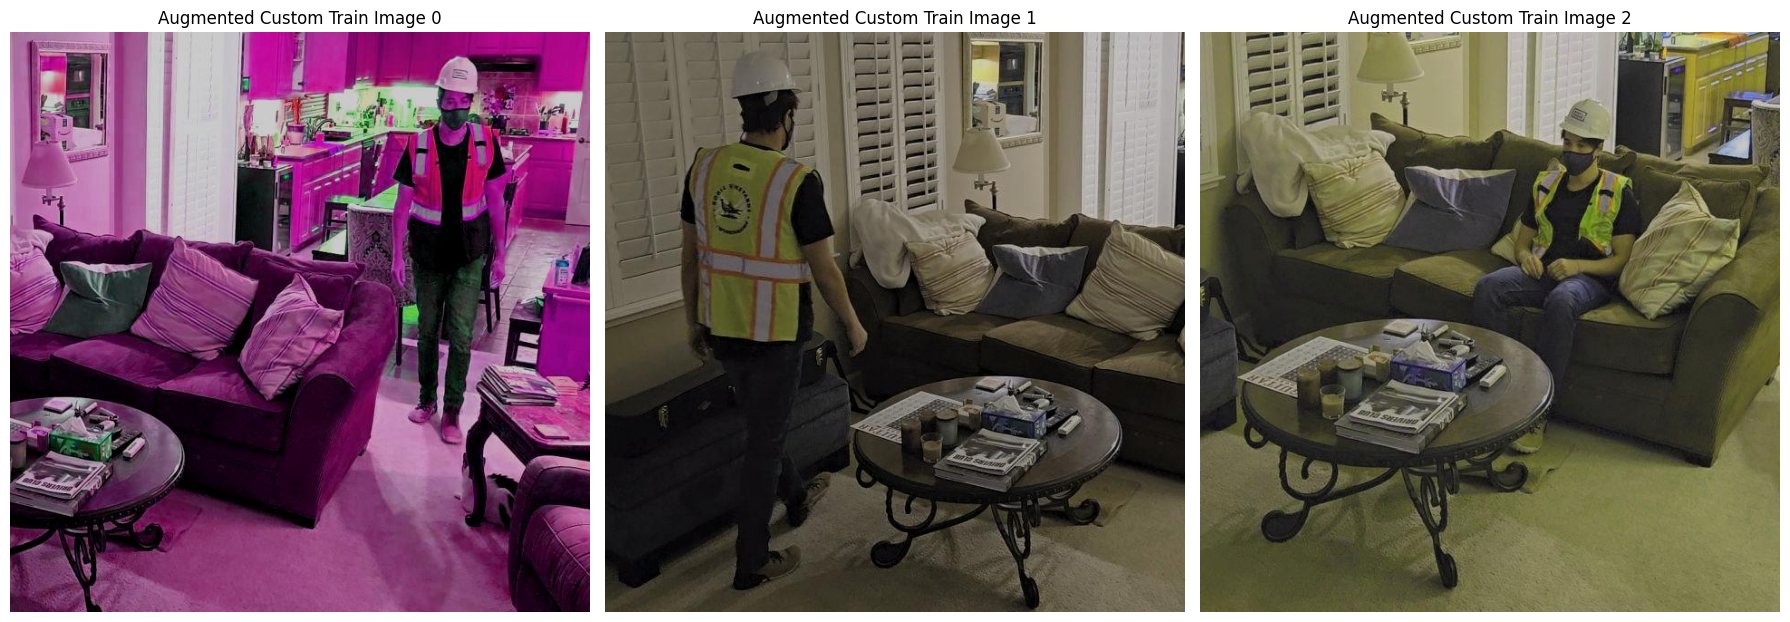

In [150]:
# Get the paths to the first three custom images
image_paths = glob.glob("./datasets/images/train/scene*.jpg")[:3]

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Adjust the figsize as needed

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Augmented Custom Train Image {i}")

    plt.tight_layout()
    plt.show()

# Train YOLOv8 from custom + construction dataset

In [151]:
# Time count
start = time.time()
for i in range(10000000):
    pass
    
# Delete all previous model runs
shutil.rmtree("./runs/", ignore_errors=True)

model = YOLO('yolov8n.pt')
model.train(data='data.yaml', epochs = 60, val = True, agnostic_nms=False, seed=88)

# Time end
end = time.time()
elapsed_seconds = end - start
elapsed_minutes = elapsed_seconds / 60
print(f"Total model train time: {elapsed_minutes:.2f} minutes")

Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=88, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_widt

train: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\test.cache... 287 im

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\valid... 571 images, 6

val: WARNING  C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\valid\004720_jpg.rf.afc486560a4004c7cfd67910af31a29c.jpg: 1 duplicate labels removed
val: WARNING  C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\valid\construction-813-_jpg.rf.b085952261fd98f2e76b8065de149b5f.jpg: 1 duplicate labels removed


val: New cache created: C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\labels\valid.cache
Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60         0G      1.471      3.795      1.543        277        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371     0.0358      0.307     0.0808      0.048



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60         0G      1.379      3.418      1.511        293        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.822     0.0553     0.0864     0.0537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60         0G      1.339      2.792      1.487        322        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371      0.815     0.0802      0.117     0.0689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60         0G      1.396       2.49      1.493        325        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.337      0.156      0.167     0.0903



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60         0G      1.326      2.274      1.476        247        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.281      0.248      0.202       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60         0G      1.376      2.148       1.48        309        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:27

                   all        571       7371      0.333      0.305       0.25      0.128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60         0G      1.347      2.075      1.483        209        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371      0.363      0.296      0.257      0.132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60         0G      1.288       1.91      1.447        243        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371      0.405      0.334      0.298       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60         0G      1.309      1.875      1.446        301        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.433      0.346      0.323      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60         0G      1.293      1.842      1.441        290        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.521      0.356      0.366      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60         0G      1.265       1.74      1.414        336        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371        0.5      0.372      0.378      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60         0G      1.232      1.671      1.407        287        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.579       0.39      0.405      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60         0G        1.2      1.639      1.375        269        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.566       0.36      0.392      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60         0G      1.179      1.613      1.383        295        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.557      0.398      0.414      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60         0G       1.19      1.585      1.367        231        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:27

                   all        571       7371      0.595      0.398      0.425      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60         0G      1.175      1.589      1.348        325        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371      0.599      0.419      0.442      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60         0G      1.169      1.523      1.345        335        640: 100%|██████████| 18/18 [00:27<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371       0.57      0.403      0.412      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60         0G       1.15      1.464      1.315        293        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.625      0.437      0.475      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60         0G      1.127      1.427      1.323        394        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.637      0.441      0.481      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60         0G      1.118      1.436      1.313        248        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.618      0.424      0.469      0.258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60         0G      1.125      1.414      1.318        256        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:22

                   all        571       7371      0.623      0.448      0.479      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60         0G      1.096      1.387      1.304        273        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.653      0.441      0.488      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60         0G      1.122      1.378      1.295        267        640: 100%|██████████| 18/18 [00:27<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.666      0.452      0.505       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60         0G      1.077      1.357      1.279        399        640: 100%|██████████| 18/18 [00:27<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:28

                   all        571       7371      0.642      0.463      0.503      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60         0G       1.07      1.301      1.274        372        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371       0.64      0.471        0.5      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60         0G      1.057      1.298      1.279        218        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.668      0.456       0.51      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60         0G      1.069      1.299      1.276        301        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.677      0.471       0.52      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60         0G      1.037      1.271      1.249        331        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.677       0.48      0.532      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60         0G      1.046       1.26      1.256        264        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.683      0.467      0.523      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60         0G      1.035      1.249      1.256        278        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.674      0.484      0.533      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60         0G       1.05      1.226      1.248        302        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.691      0.466      0.529      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60         0G      1.019      1.195      1.233        294        640: 100%|██████████| 18/18 [00:27<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.687      0.492      0.544      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60         0G      1.025      1.178      1.233        234        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.686      0.485      0.544      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/60         0G     0.9951       1.18      1.231        341        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.685      0.482      0.537      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/60         0G      1.034      1.159      1.226        222        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371        0.7      0.504      0.557      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/60         0G      1.003      1.183      1.224        336        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.679      0.502      0.551      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/60         0G     0.9817      1.181      1.236        338        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.697      0.493      0.552      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/60         0G     0.9658      1.155      1.197        185        640: 100%|██████████| 18/18 [00:27<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371        0.7      0.491      0.552      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/60         0G     0.9632      1.133      1.208        261        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.681      0.514      0.567      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/60         0G     0.9285      1.101      1.192        332        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.704       0.51      0.568       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/60         0G     0.9443      1.098      1.198        248        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.702      0.508       0.57      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/60         0G     0.9671      1.108      1.201        309        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.688      0.526      0.576      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/60         0G     0.9332      1.094      1.184        256        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.709       0.51      0.573      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/60         0G     0.9683      1.088      1.215        403        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371       0.72      0.505      0.571      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/60         0G     0.9209      1.064      1.194        336        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.729      0.517      0.576       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/60         0G     0.9252      1.057      1.182        362        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.731      0.519      0.583      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/60         0G     0.9418      1.075      1.191        294        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:21

                   all        571       7371      0.723      0.527      0.586      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/60         0G     0.9167      1.028      1.165        356        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371       0.74      0.524       0.59      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/60         0G      0.925      1.054       1.18        341        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.726      0.531      0.593      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/60         0G     0.8999      1.037      1.171        352        640: 100%|██████████| 18/18 [00:26<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.724      0.535      0.596      0.348


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/60         0G     0.9327       1.07      1.192        171        640: 100%|██████████| 18/18 [00:27<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.743       0.52      0.591      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/60         0G     0.9255       1.04        1.2        169        640: 100%|██████████| 18/18 [00:24<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:22

                   all        571       7371      0.733      0.509      0.575      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/60         0G     0.9245      1.035      1.179        156        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.741      0.516      0.583      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/60         0G     0.8924     0.9867      1.173        176        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.735       0.52      0.589      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/60         0G     0.8758     0.9502      1.147        242        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:22

                   all        571       7371      0.735      0.533      0.594      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/60         0G     0.8743     0.9298      1.158        200        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:22

                   all        571       7371      0.733      0.536      0.596      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/60         0G     0.8705     0.9469      1.147        210        640: 100%|██████████| 18/18 [00:22<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:23

                   all        571       7371      0.741      0.536      0.598      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/60         0G     0.8544     0.9324      1.137        168        640: 100%|██████████| 18/18 [00:23<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:24

                   all        571       7371      0.732      0.544        0.6      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/60         0G     0.8611     0.9359      1.148        226        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:26

                   all        571       7371      0.746      0.537        0.6      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/60         0G     0.8639     0.9358      1.146        332        640: 100%|██████████| 18/18 [00:25<00:00,  1.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:25

                   all        571       7371      0.749      0.539      0.602      0.353



60 epochs completed in 0.843 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train\weights\best.pt, 6.3MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.32  Python-3.12.4 torch-2.5.1+cpu CPU (Intel Core(TM) i9-14900KF)
Model summary (fused): 168 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:20


                   all        571       7371       0.75      0.539      0.602      0.353
               Hardhat        273        673      0.828      0.545      0.621      0.358
                  Mask        227        326      0.866      0.727        0.8      0.498
            NO-Hardhat        287        464      0.726      0.466      0.518      0.268
               NO-Mask        313        651      0.635      0.344      0.386      0.147
        NO-Safety Vest        389        790      0.733      0.451      0.536      0.296
                Person        544       1922      0.801      0.649      0.729      0.482
           Safety Cone        136        631      0.689      0.493      0.539      0.223
           Safety Vest        284        636      0.738      0.555      0.612      0.352
             Machinery        412        999      0.709      0.698      0.743      0.538
               Vehicle        149        279      0.772      0.462      0.536      0.365
Speed: 0.5ms preproce

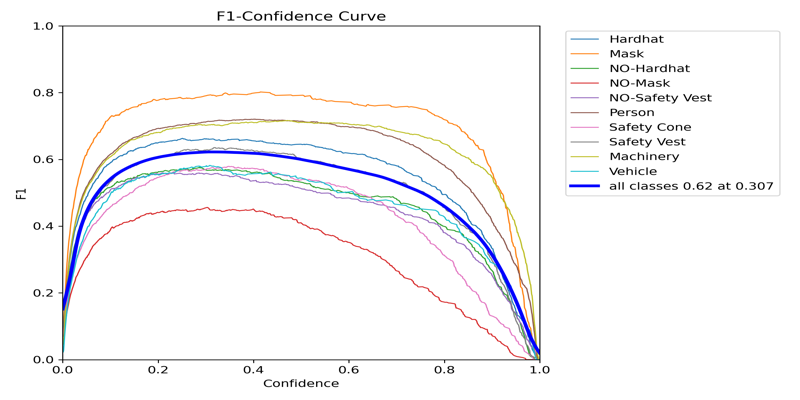

In [152]:
# Show conf curve
image_path = "./runs/detect/train/F1_curve.png"
Image.open(image_path).resize((800,400))

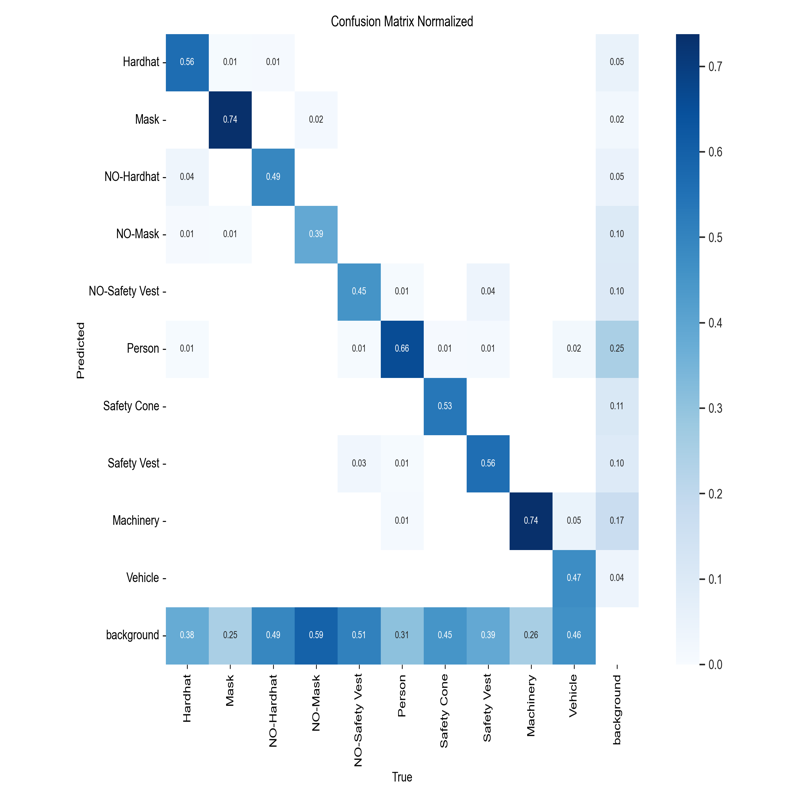

In [153]:
# Show canf matrix
image_path = "./runs/detect/train/confusion_matrix_normalized.png"
Image.open(image_path).resize((800,800))

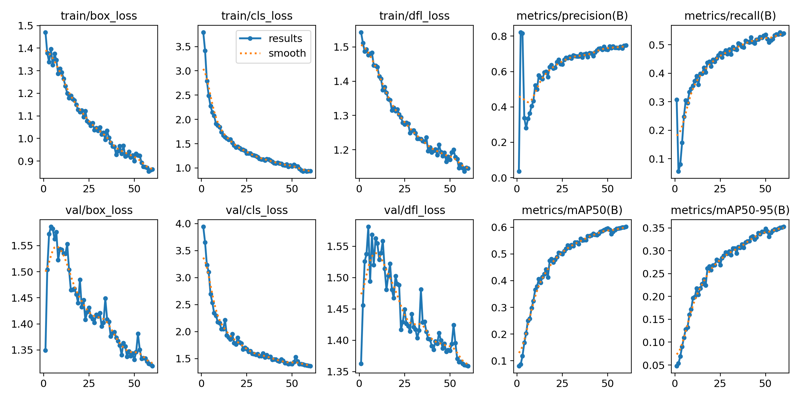

In [154]:
# Show conf curve
image_path = "./runs/detect/train/results.png"
Image.open(image_path).resize((800,400))

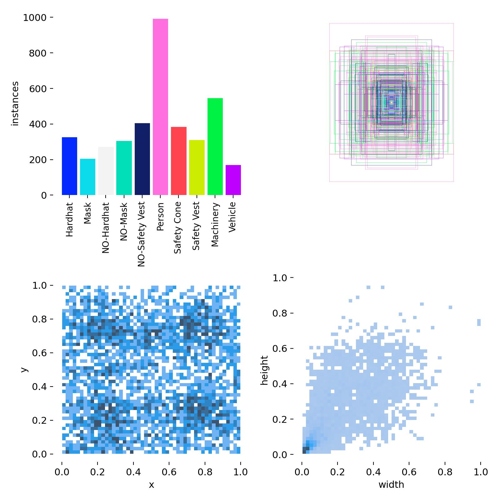

In [155]:
# Show labels diagrams
image_path = "runs/detect/train/labels.jpg"
Image.open(image_path).resize((500,500))

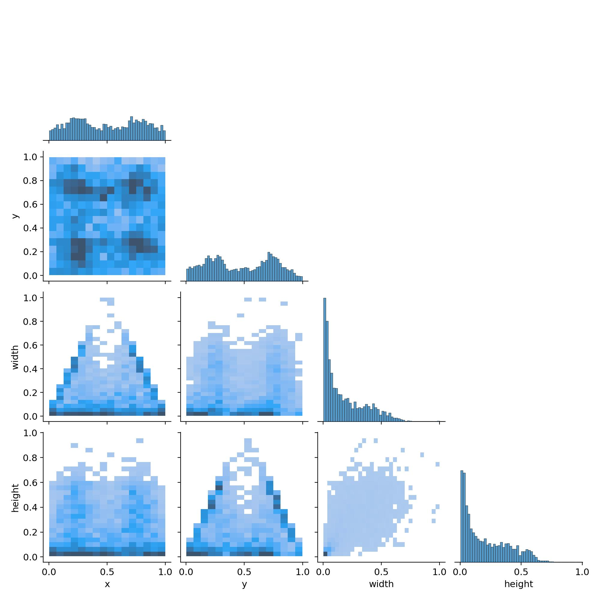

In [156]:
# Show correlogram
image_path = "runs/detect/train/labels_correlogram.jpg"
Image.open(image_path).resize((600,600))

# Images from test folder:

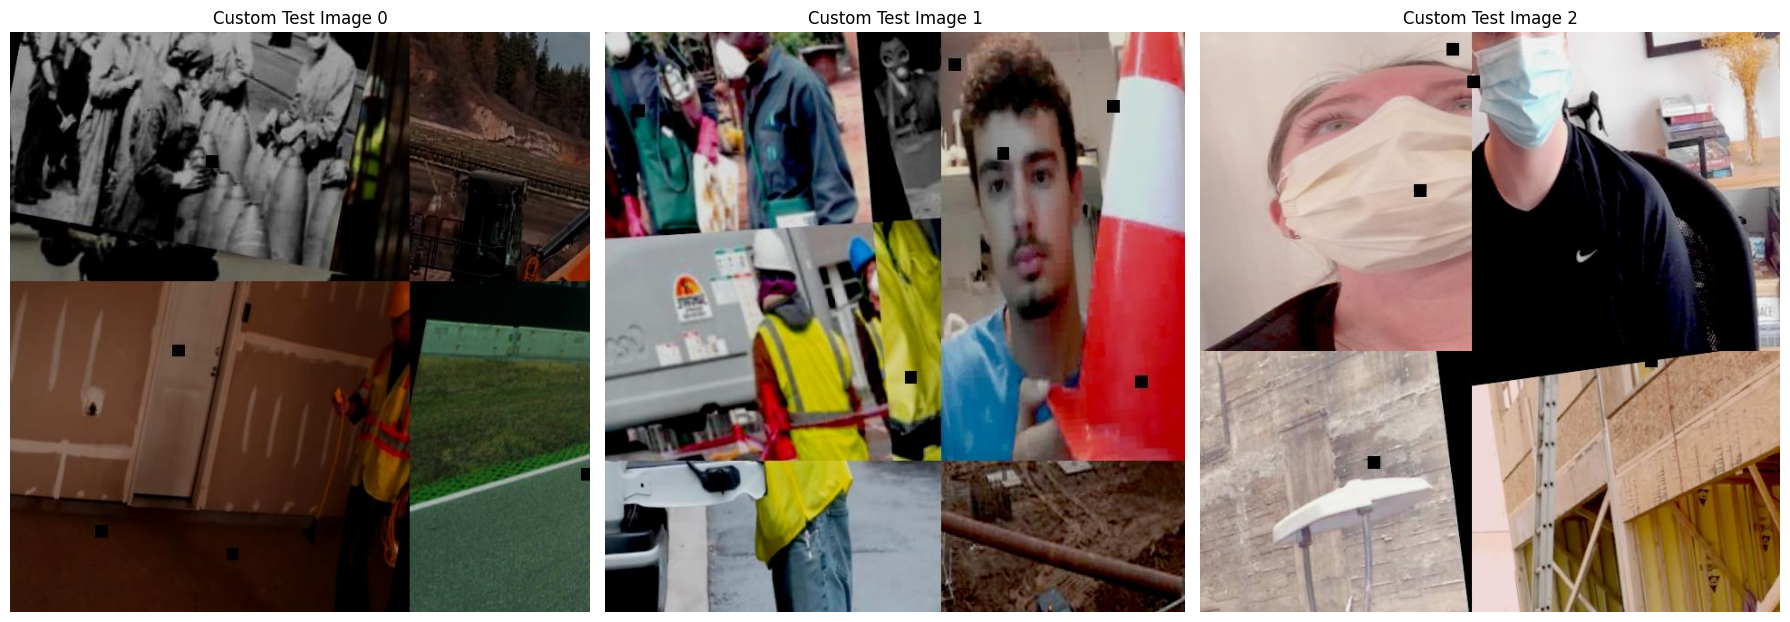

In [157]:
# Get the paths to the first three custom images
image_paths = glob.glob("./datasets/images/test/scene*.jpg")[:3] # modify file desc as needed

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Adjust the figsize as needed

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        ax.axis('off')  # Hide axes
        ax.set_title(f"Custom Test Image {i}") # modify file desc as needed

    plt.tight_layout()
    plt.show()

# Predict test images with fine tuned model (best.pt)

In [160]:
# Remove previous predictions
# Path to the detect folder
detect_path = "./runs/detect/"
# Iterate through subdirectories and delete folders starting with "predict"
for folder in os.listdir(detect_path):
    folder_path = os.path.join(detect_path, folder)
    if os.path.isdir(folder_path) and folder.startswith("predict"):
        shutil.rmtree(folder_path, ignore_errors=True)

# model = runs/detect/train/weights/best.pt
model = YOLO("runs/detect/train/weights/best.pt")

# Run inference on any custom image in the test folder
model.predict("./datasets/images/test/scene*.jpg", save=True, imgsz=640, conf=0.45, agnostic_nms=True, iou=0.4) # modify file desc as needed


image 1/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene1_all_2.jpg: 640x640 1 Hardhat, 1 Mask, 1 Person, 45.0ms
image 2/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene1_hatmask_2.jpg: 640x640 1 Hardhat, 1 Mask, 1 NO-Safety Vest, 35.0ms
image 3/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene1_none_1.jpg: 640x640 1 NO-Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 32.5ms
image 4/4 C:\Users\DARiN\Documents\Python-JL\Github\aai-501-final-project_dv\datasets\images\test\scene3_none_5.jpg: 640x640 1 NO-Hardhat, 1 NO-Mask, 1 NO-Safety Vest, 1 Person, 41.0ms
Speed: 1.5ms preprocess, 38.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Hardhat', 1: 'Mask', 2: 'NO-Hardhat', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'Machinery', 9: 'Vehicle'}
 obb: None
 orig_img: array([[[138, 158, 189],
         [136, 157, 188],
         [132, 156, 186],
         ...,
         [103, 146, 173],
         [104, 144, 172],
         [104, 144, 172]],
 
        [[140, 160, 191],
         [137, 158, 189],
         [132, 156, 186],
         ...,
         [104, 147, 174],
         [105, 145, 173],
         [104, 144, 172]],
 
        [[140, 161, 189],
         [137, 159, 187],
         [129, 153, 183],
         ...,
         [105, 145, 173],
         [104, 145, 170],
         [103, 144, 169]],
 
        ...,
 
        [[ 58, 100, 129],
         [ 58, 100, 129],
         [ 57,  99, 128],
         ...,
         [ 33,  32,  41],
         [ 40,  39,  4

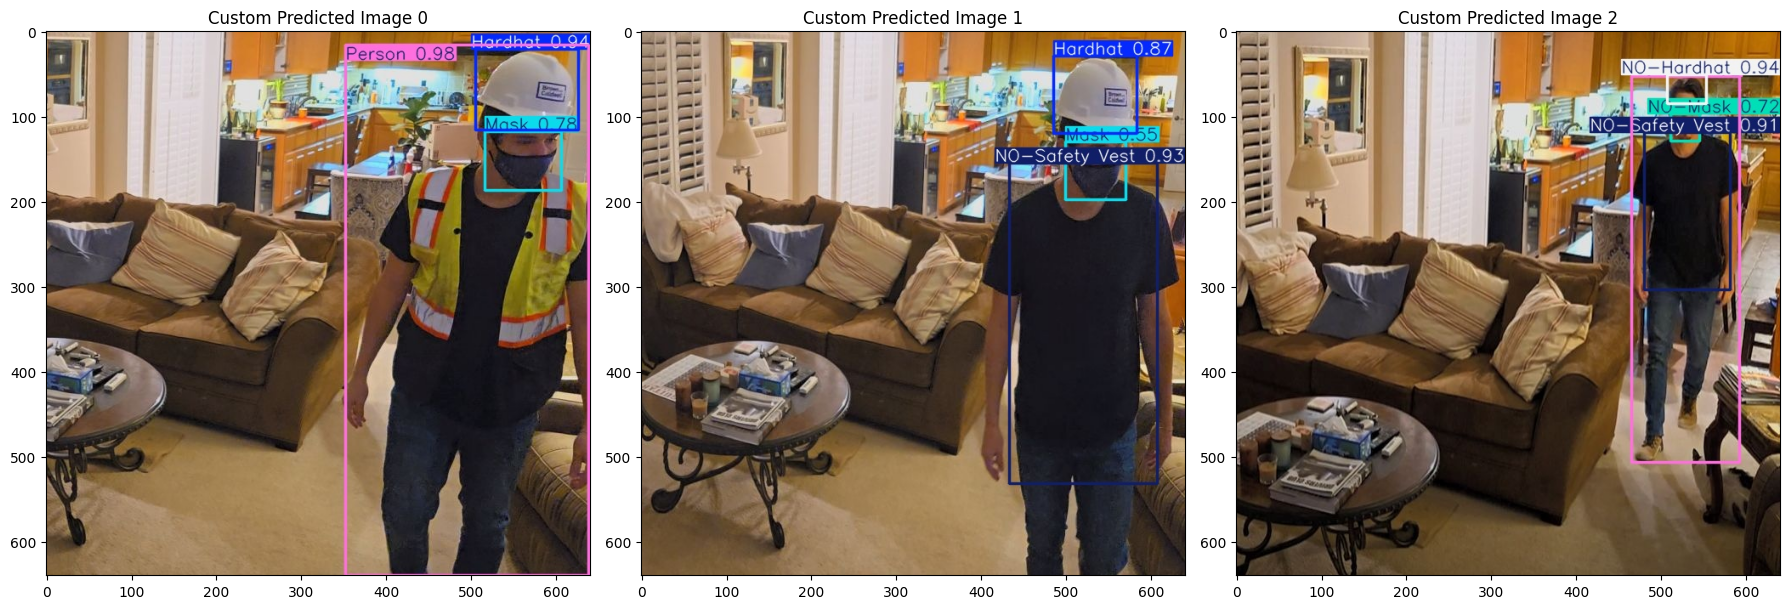

In [159]:
# Get the paths to the first three custom images
image_paths = glob.glob("./runs/detect/predict/scene*.jpg")[:3] # modify file desc as needed

# Check if there are enough images
if len(image_paths) < 3:
    print("Not enough images found!")
else:
    # Create a subplot with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(18, 7))  # Adjust the figsize as needed

    for i, ax in enumerate(axes):
        # Load and display each image
        image = mpimg.imread(image_paths[i])
        ax.imshow(image)
        # ax.axis('on')  # Hide axes
        ax.set_title(f"Custom Predicted Image {i}") # modify file desc as needed

    plt.tight_layout()
    plt.show()